In [1]:
%matplotlib inline

# Initialization / Optimizers / Regularization / Dropout

Besides the architecture, other aspects have deep impact in the network's performance. In this exercise, we will examine how weights initialization, regularization, dropout and the optimizers influence our training. 

## Utility methods
First let's import some prerequisites:

In [2]:
import numpy as np
from random import seed, sample
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from sklearn.datasets import make_classification

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras import optimizers, regularizers, initializers

from matplotlib.colors import ListedColormap
        
        
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()
    plt.show()
 
def make_synth_dataset():
    X, Y = make_classification(n_samples = 150, n_features=2, n_redundant=0, n_informative=2, class_sep=2, random_state=20)
    testIdx = sample(list(range(150)), 50)
    
    X_test = np.array([X[i] for i in testIdx])
    Y_test = np.array([Y[i] for i in testIdx])
    
    X_train = np.array([X[i] for i in list(range(150)) if i not in testIdx])
    Y_train = np.array([Y[i] for i in list(range(150)) if i not in testIdx])
    
    return X_train, Y_train, X_test, Y_test
    
def make_synth_dataset_with_noise():
    X, Y = make_classification(n_samples = 150, n_features=2, n_redundant=0, n_informative=2, class_sep=2, random_state=20)
    testIdx = sample(list(range(150)), 50)
    
    X_test = np.array([X[i] for i in testIdx])
    Y_test = np.array([Y[i] for i in testIdx])
    
    X_train = np.array([X[i] for i in list(range(150)) if i not in testIdx])
    Y_train = np.array([Y[i] for i in list(range(150)) if i not in testIdx])

    noise_X = [ (1.5,-0.5), (1.6,-0.5),(1.4,-0.5), (1.5,-0.4),(1.5,-0.6)]
    noise_Y = [0 for sample in noise_X]

    X_train = np.concatenate((X_train, noise_X), axis=0)
    Y_train = np.concatenate((Y_train, noise_Y), axis=0)
    
    return X_train, Y_train, X_test, Y_test
    

def plot_decision_boundary(func, X, y, title, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)
    plt.title(title)
    plt.show()

    
def plot_loss_accuracy(history, legend, plotSet="both"):
    linestyles = ['-', '--', ':', '-.']

    #Plot Loss
    plt.subplot(2, 1, 1)

    for idx,hist in enumerate(historyList):
        if plotSet in ["train", "both"]:
            plt.plot(hist.history['loss'], linestyle=linestyles[idx%len(linestyles)])
        if 'val_loss' in hist.history.keys() and plotSet in ["test", "both"]:
            plt.plot(hist.history['val_loss'], linestyle=linestyles[idx%len(linestyles)])

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title("Loss")    
    plt.legend(legend, loc='best')    

    #Plot ACC
    plt.subplot(2, 1, 2)
    for idx,hist in enumerate(historyList):    
        if plotSet in ["train", "both"]:
            plt.plot(hist.history['acc'], linestyle=linestyles[idx%len(linestyles)])
        if 'val_acc' in hist.history.keys() and plotSet in ["test", "both"]:
            plt.plot(hist.history['val_acc'], linestyle=linestyles[idx%len(linestyles)])

    plt.ylabel('ACC')
    plt.xlabel('Epoch')
    plt.title("ACC")   
    plt.legend(legend, loc='best')    

    plt.show()

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Generate synthetic data

Training Data without noise


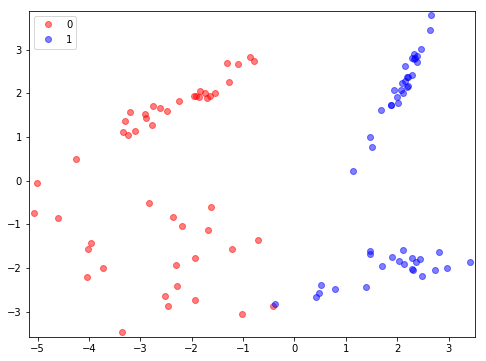

Testing Data


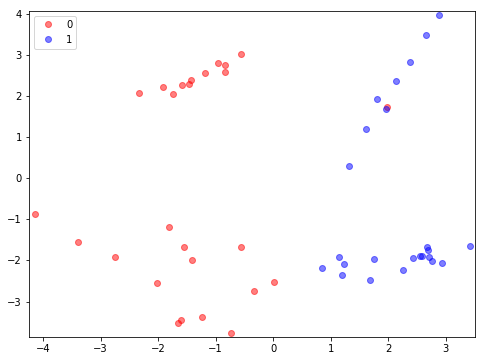

Training Data with noise


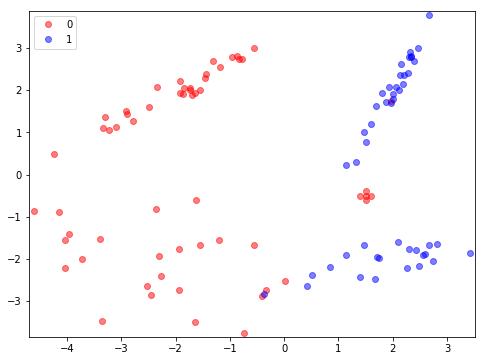

In [3]:
X_train, Y_train, X_test, Y_test = make_synth_dataset()
X_reg_train, Y_reg_train, X_reg_test, Y_reg_test = make_synth_dataset_with_noise()

print("Training Data without noise")
plot_data(X_train, Y_train)
print("Testing Data")
plot_data(X_test, Y_test)
print("Training Data with noise")
plot_data(X_reg_train, Y_reg_train)

----------
# Weights Initialization
Depending on how you choose to initialize the network's weights, the network may converge faster/slower or not converge at all.

Keras has a number of [initializers available](https://keras.io/initializers), from random initialization to, one of the most used, Xavier initialization (`glorot_uniform`).

The default initialization in Keras is `glorot_uniform` for weights and `zeros` for the bias.

In [4]:
historyList = []
initTypes = ["zeros", "random_normal", "glorot_uniform"]
for initialization in initTypes:
    #Network definition
    model = Sequential()
    model.add(Dense(64, input_shape=(2,), activation='tanh', kernel_initializer = initialization))
    model.add(Dense(64, activation='tanh', kernel_initializer = initialization))
    model.add(Dense(64, activation='tanh', kernel_initializer = initialization))
    model.add(Dense(64, activation='tanh', kernel_initializer = initialization))
    model.add(Dense(1, activation='sigmoid', kernel_initializer = initialization))

    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    historyList.append(model.fit(X_train, Y_train, epochs=200, verbose=0, validation_data=(X_test, Y_test)))    

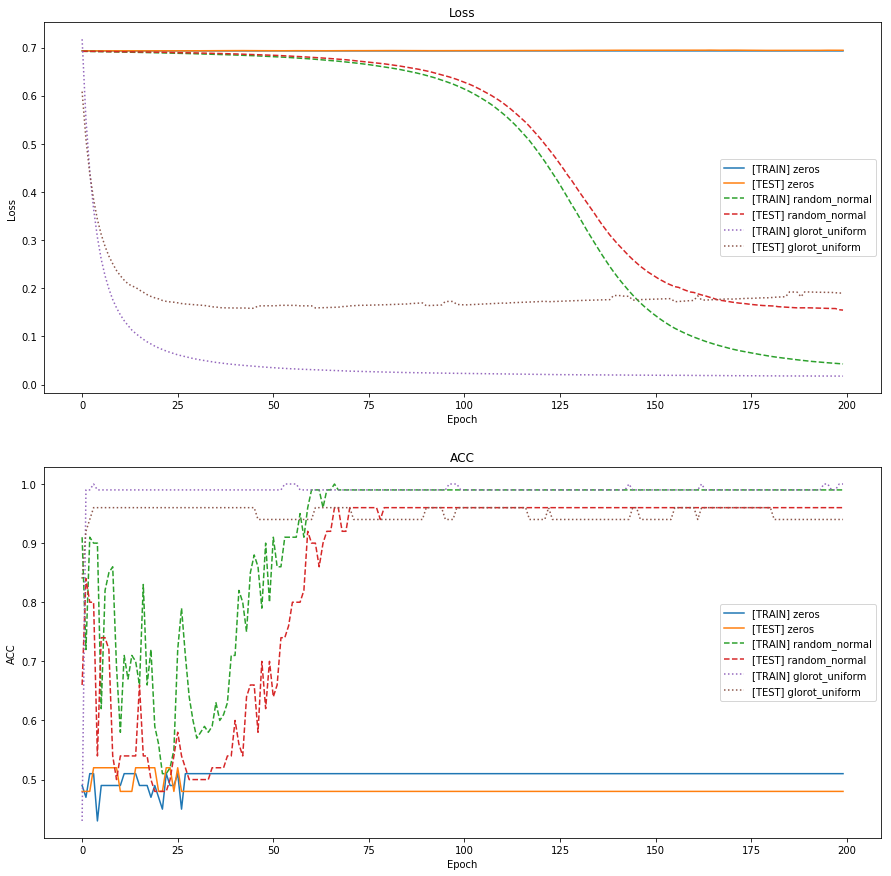

In [5]:
legend = ["[TRAIN] zeros", "[TEST] zeros", 
          "[TRAIN] random_normal", "[TEST] random_normal",
          "[TRAIN] glorot_uniform", "[TEST] glorot_uniform"]
plot_loss_accuracy(historyList, legend)

----------
# Optimizers
[Available optimizers implemented in Keras.](https://keras.io/optimizers/)

In [6]:
historyList = []
optimizers = ["sgd", "adam","adagrad", "rmsprop"]
for opt in optimizers:
    #Network definition
    model = Sequential()
    model.add(Dense(20, input_shape=(2,), activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    historyList.append(model.fit(X_train, Y_train, epochs=20, verbose=0, validation_data=(X_test, Y_test)))    

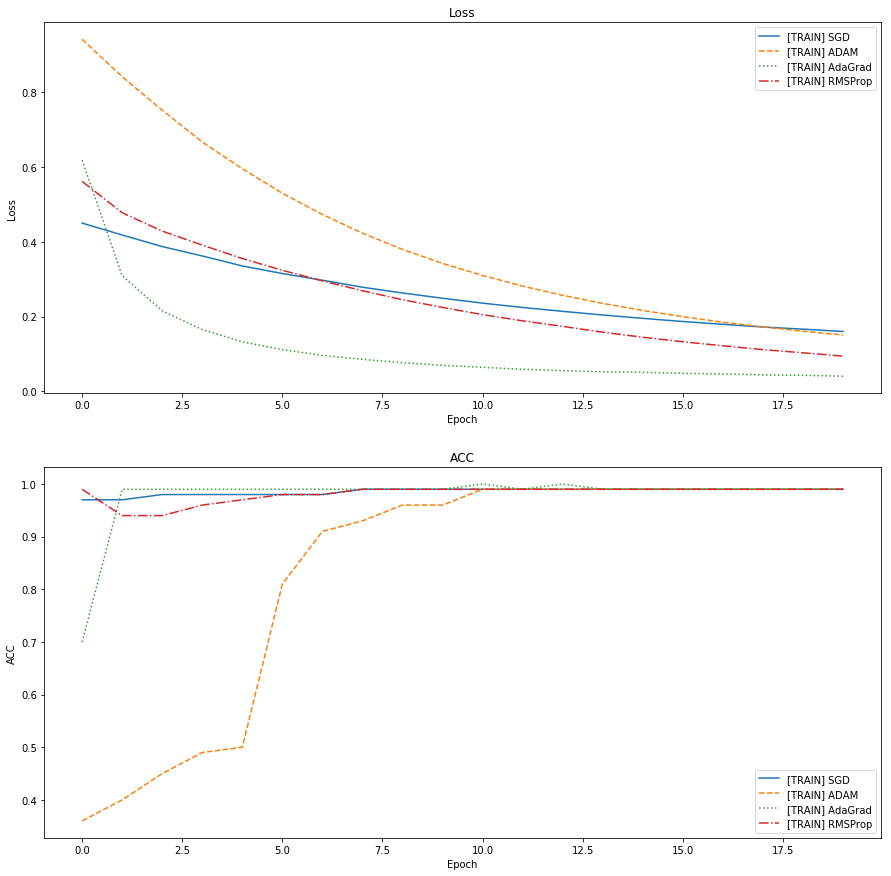

In [7]:
legend = ["[TRAIN] SGD", "[TRAIN] ADAM", "[TRAIN] AdaGrad", "[TRAIN] RMSProp"]
plot_loss_accuracy(historyList, legend, "train")

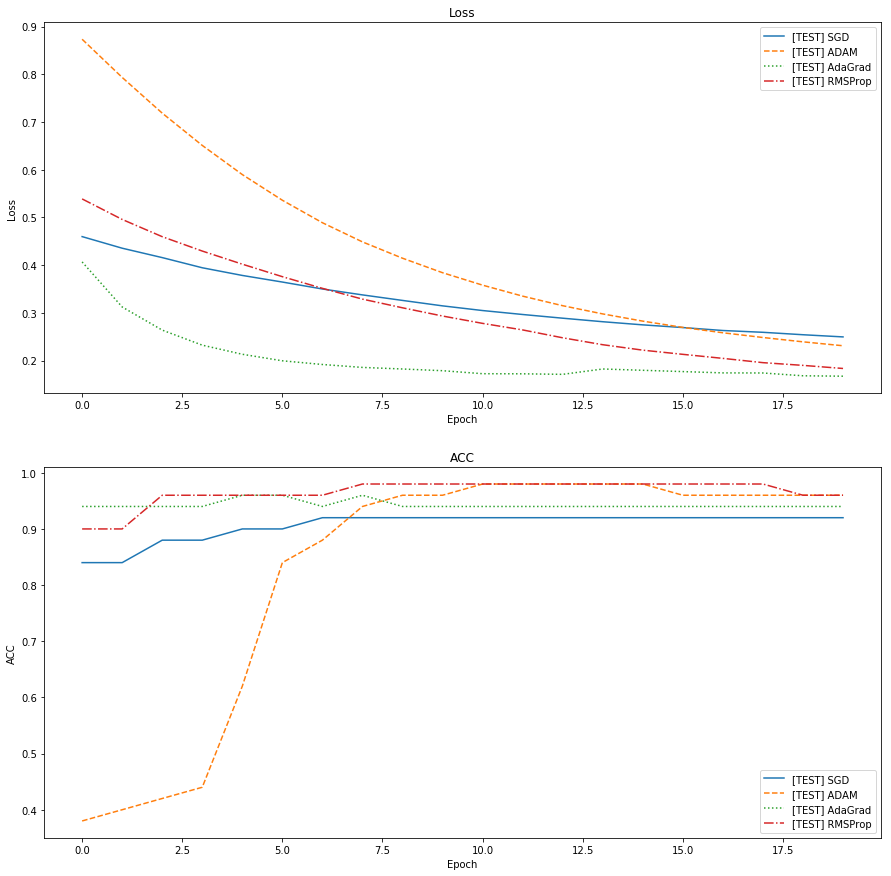

In [8]:
legend = ["[TEST] SGD", "[TEST] ADAM", "[TEST] AdaGrad", "[TEST] RMSProp"]
plot_loss_accuracy(historyList, legend, "test")

----------
# Regularization (L2)
Keras documentation on [Regularizers](https://keras.io/regularizers/).

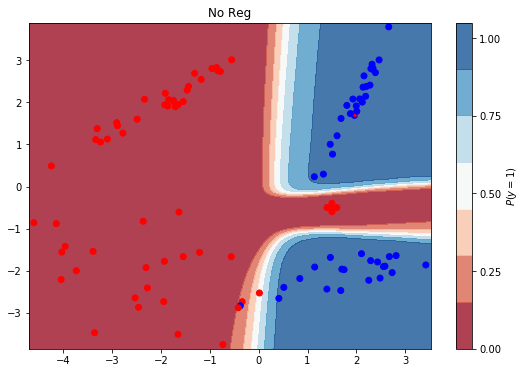

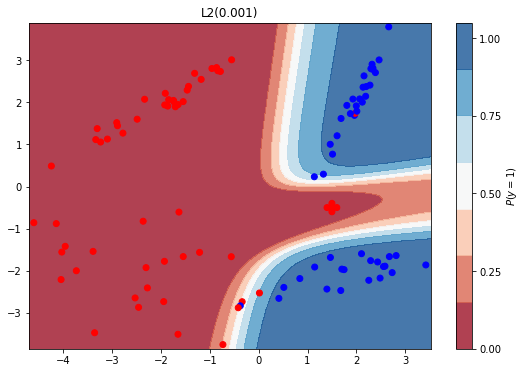

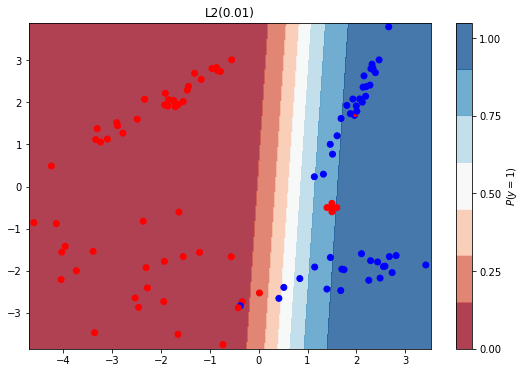

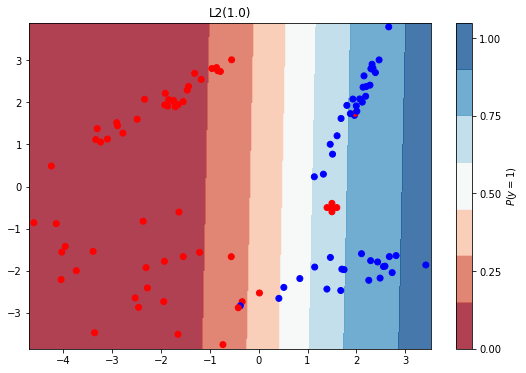

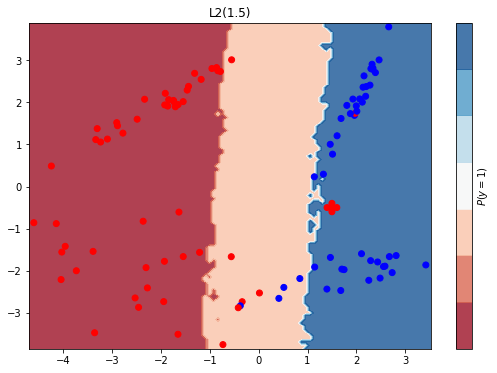

In [9]:
title = ["No Reg", "L2(0.001)", "L2(0.01)", "L2(1.0)", "L2(1.5)"]
regularization = [None, regularizers.l2(0.001), regularizers.l2(0.01), regularizers.l2(1.0), regularizers.l2(1.5)]
for i in list(range(len(regularization))):
    # Make model
    model = Sequential()
    model.add(Dense(64, input_shape=(2,), activation='tanh', kernel_regularizer = regularization[i]))
    model.add(Dense(64, activation='tanh', kernel_regularizer = regularization[i]))
    model.add(Dense(1, activation='sigmoid'))
    from keras.optimizers import Adam

    model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_reg_train, Y_reg_train, verbose=0, epochs=100)
    plot_decision_boundary(lambda x: model.predict(x), X_reg_train, Y_reg_train, title[i])

---------
# Dropout
[Keras documentation of the Dropout layer](https://keras.io/layers/core/#dropout)

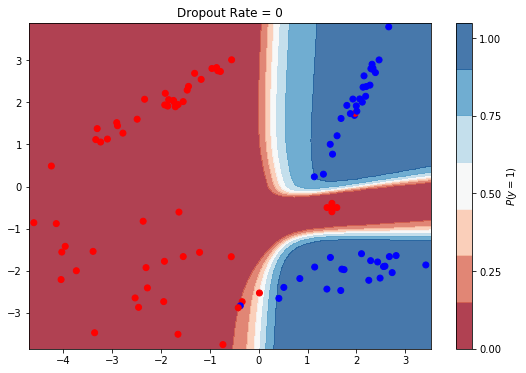

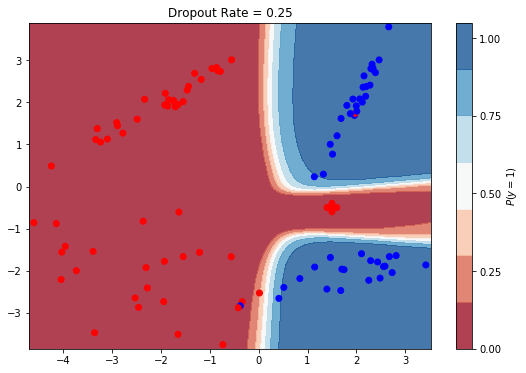

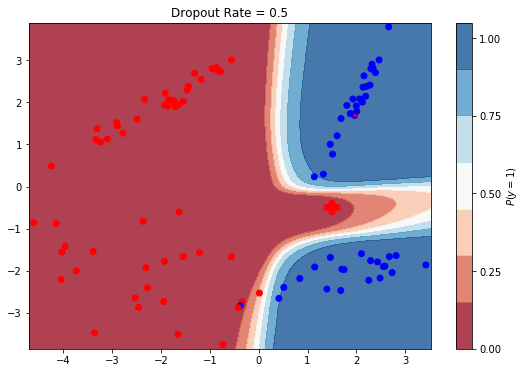

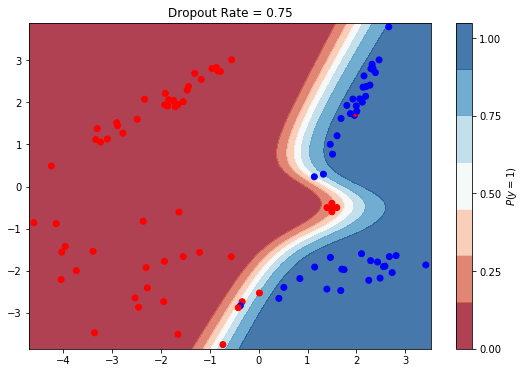

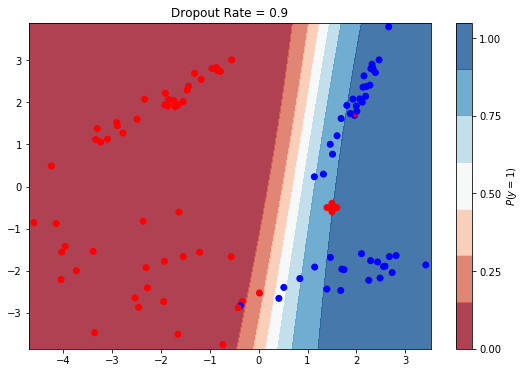

In [10]:
dropoutRate = [0, 0.25, 0.5, 0.75, 0.9]
for rate in dropoutRate:
    model = Sequential()
    model.add(Dense(64, input_shape=(2,), activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(rate))
    model.add(Dense(1, activation='sigmoid'))
    from keras.optimizers import Adam

    model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_reg_train, Y_reg_train, verbose=0, epochs=100)
    plot_decision_boundary(lambda x: model.predict(x), X_reg_train, Y_reg_train, "Dropout Rate = " + str(rate))